In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('../DATA/RSCCASN.csv',parse_dates=True,index_col='DATE')
#parse_dates-find the string that seems to be a date and convert them to data time object
#index_col='column name' makes that column as an index
#data set of clothing and textile buisiness in sales

In [3]:
data

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


<AxesSubplot:xlabel='DATE'>

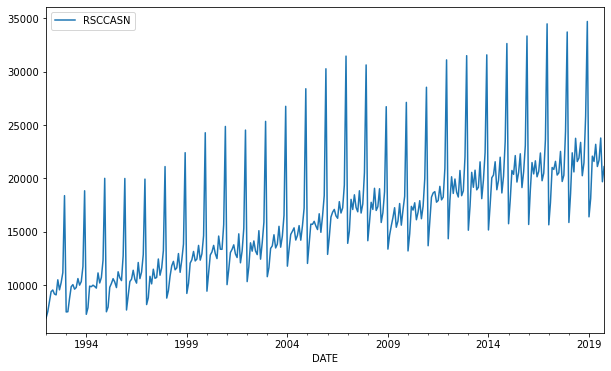

In [4]:
data.plot(figsize=(10,6))

In [5]:
len(data)

334

In [6]:
#lets leave 1.5 years as test data
test_len=16
test_index=len(data)-test_len

In [7]:
train=data.iloc[:test_index]
test=data.iloc[-test_len:]

In [8]:
len(train)

318

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
sc=MinMaxScaler()

In [11]:
scaled_train=sc.fit_transform(train)
scaled_test=sc.transform(test)

In [12]:
#create generator(seperate batches to train and test)
#since length should be lesser than len of test data (16)(only in test genratir)..to make a meaningfull selection(year),let us choose 12(1 year)
length=12
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [13]:
generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [14]:
x,y=generator[0]

In [15]:
x

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [16]:
y

array([[0.02047633]])

In [17]:
len(generator)#len of train-length

306

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [19]:
n_feat=1#since it has only one col except the index

In [20]:
sq=Sequential()
sq.add(LSTM(100,activation='relu',input_shape=(length,n_feat)))# no of nuerons is optional
sq.add(Dense(1))
sq.compile(loss='mse',optimizer='adam')

In [21]:
#callbacks
from tensorflow.keras.callbacks import EarlyStopping
stop=EarlyStopping(monitor='val_loss',patience=2)#it is good to have patience as 2 as it can act to noise

In [22]:
#validation_generator
validation_generator=TimeseriesGenerator(scaled_test,scaled_test,length,batch_size=1)

In [23]:
sq.fit(generator,validation_data=validation_generator,callbacks=stop,epochs=20)

Epoch 1/20
306/306 [==============================] - 3s 11ms/step - loss: 0.0224 - val_loss: 0.0191
Epoch 2/20
306/306 [==============================] - 3s 10ms/step - loss: 0.0166 - val_loss: 0.0162
Epoch 3/20
306/306 [==============================] - 3s 11ms/step - loss: 0.0065 - val_loss: 5.2289e-04
Epoch 4/20
306/306 [==============================] - 3s 10ms/step - loss: 0.0085 - val_loss: 7.9020e-04
Epoch 5/20
306/306 [==============================] - 3s 10ms/step - loss: 0.0030 - val_loss: 0.0024


In [24]:
history=pd.DataFrame(sq.history.history)

In [25]:
history

,loss,val_loss
0,0.022416,0.019083
1,0.016604,0.016226
2,0.006484,0.000523
3,0.008545,0.000790
4,0.003038,0.002407


<AxesSubplot:>

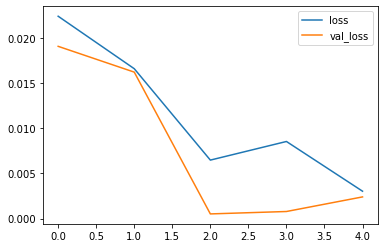

In [26]:
history.plot()

In [27]:

[[sq.predict(scaled_test.reshape(-1,16,1))[0]]]

[[array([0.50554127], dtype=float32)]]

In [84]:
predict=[]
curr_batch=scaled_test.reshape(-1,16,1)

for i in range(16):#len of test data
    pred=sq.predict(curr_batch)
    curr_batch=np.append(curr_batch[:,1::],[[pred[0]]],axis=1)
    predict.append(pred[0])
         

In [85]:
predict

[array([0.48384762], dtype=float32),
 array([0.527426], dtype=float32),
 array([0.43567482], dtype=float32),
 array([0.47176945], dtype=float32),
 array([0.61358374], dtype=float32),
 array([0.9506982], dtype=float32),
 array([0.2949001], dtype=float32),
 array([0.36379868], dtype=float32),
 array([0.47374296], dtype=float32),
 array([0.46484077], dtype=float32),
 array([0.51412755], dtype=float32),
 array([0.45219356], dtype=float32),
 array([0.47090226], dtype=float32),
 array([0.533213], dtype=float32),
 array([0.40808186], dtype=float32),
 array([0.45062682], dtype=float32)]

In [86]:
true_predict=sc.inverse_transform(predict)

In [87]:
true_predict

array([[20265.09879303],
       [21465.42186546],
       [18938.2271421 ],
       [19932.41778851],
       [23838.55063295],
       [33124.03113508],
       [15060.72806525],
       [16958.47078466],
       [19986.77614212],
       [19741.57416248],
       [21099.12930632],
       [19393.2193675 ],
       [19908.53196287],
       [21624.81940556],
       [18178.20673394],
       [19350.06513906]])

In [88]:
test['pred']=true_predict

<ipython-input-88-cc67c4121f9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred']=true_predict


<AxesSubplot:xlabel='DATE'>

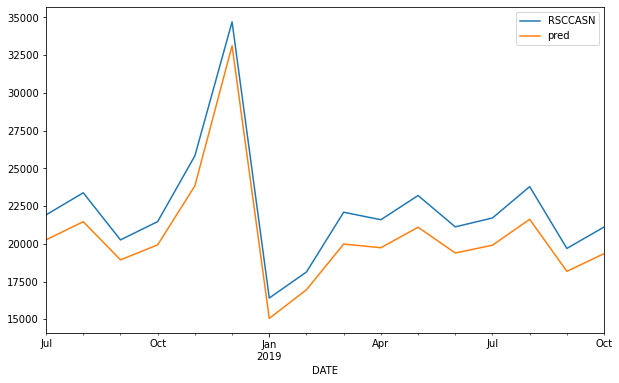

In [89]:
test.plot(figsize=(10,6))

In [34]:
#predict the future data(forcast) without knowing the true data
data

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [35]:
#scale the toatal data
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(data)
scaled_data

array([[0.        ],
       [0.02110343],
       [0.05535148],
       [0.08869922],
       [0.09435321],
       [0.08081245],
       [0.07796744],
       [0.12874532],
       [0.0948934 ],
       [0.11941804],
       [0.15301786],
       [0.41259723],
       [0.02031115],
       [0.02110343],
       [0.06583117],
       [0.10548113],
       [0.11253961],
       [0.09712619],
       [0.1028522 ],
       [0.13288678],
       [0.11073898],
       [0.1227312 ],
       [0.17365313],
       [0.42901901],
       [0.01231634],
       [0.03471622],
       [0.10742581],
       [0.10555315],
       [0.11059493],
       [0.10641746],
       [0.10072746],
       [0.15193748],
       [0.11808557],
       [0.13656007],
       [0.19504466],
       [0.47097378],
       [0.02088735],
       [0.03684097],
       [0.10360847],
       [0.11632094],
       [0.13259867],
       [0.12111063],
       [0.10249208],
       [0.15579084],
       [0.13583982],
       [0.12608038],
       [0.20934169],
       [0.470

In [36]:
#create generator
full_gen=TimeseriesGenerator(scaled_data,scaled_data,length=12,batch_size=1)#length=12

In [57]:
#model
sqm=Sequential()
sqm.add(LSTM(100,input_shape=(12,1),activation='relu'))
sqm.add(Dense(1))
sqm.compile(loss='mse',optimizer='adam')

In [58]:
sqm.fit_generator(full_gen,epochs=8)#lastly found epoch ..since we cant early stop as we dont know the future data

Epoch 1/8
322/322 [==============================] - 2s 8ms/step - loss: 0.0255
Epoch 2/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0179
Epoch 3/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0088
Epoch 4/8
322/322 [==============================] - 2s 8ms/step - loss: 0.0042
Epoch 5/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0021
Epoch 6/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0015
Epoch 7/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0016


In [72]:
dum=scaler.inverse_transform(scaled_data[-12:])
pred=sqm.predict(scaled_data[-12:].reshape(1,12,1))
scaler.inverse_transform(pred)
scaled_data.shape

(334, 1)

In [90]:
forcast=[]
entire_batch=scaled_data[-12:]
entire_batch=entire_batch.reshape(1,12,1)
for i in range(12):
    pred=sqm.predict(entire_batch)
    entire_batch=np.append(entire_batch[:,1::],[[pred[0]]],axis=1)
    forcast.append(pred[0])

In [91]:
forcast

[array([0.6988026], dtype=float32),
 array([1.0519294], dtype=float32),
 array([0.3615295], dtype=float32),
 array([0.42392188], dtype=float32),
 array([0.5599737], dtype=float32),
 array([0.5417316], dtype=float32),
 array([0.5995972], dtype=float32),
 array([0.5260428], dtype=float32),
 array([0.54739016], dtype=float32),
 array([0.621406], dtype=float32),
 array([0.48176777], dtype=float32),
 array([0.53063536], dtype=float32)]

In [92]:
sforcast=scaler.inverse_transform(forcast)

In [93]:
sforcast

array([[26342.3503294 ],
       [36147.97432041],
       [16976.95113635],
       [18709.46285009],
       [22487.35016632],
       [21980.80295753],
       [23587.61548424],
       [21545.15699863],
       [22137.93004465],
       [24193.20232821],
       [20315.72753811],
       [21672.68259048]])

<AxesSubplot:>

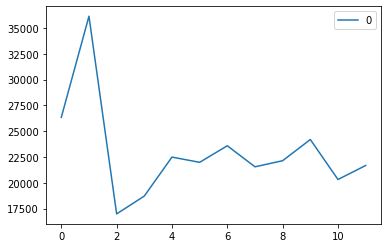

In [94]:
ddf=pd.DataFrame(sforcast)
ddf.plot()

In [95]:
data

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [96]:
dataindex=pd.date_range(start='2019-11-01',periods=12,freq='MS')

In [97]:
next=pd.DataFrame(sforcast,index=dataindex)
next

,0
2019-11-01,26342.350329
2019-12-01,36147.974320
2020-01-01,16976.951136
2020-02-01,18709.462850
2020-03-01,22487.350166
2020-04-01,21980.802958
2020-05-01,23587.615484
2020-06-01,21545.156999
2020-07-01,22137.930045
2020-08-01,24193.202328


(576.0, 611.0)

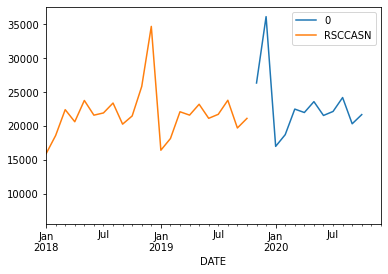

In [98]:
ax=next.plot()
data.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')